In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import plotly.express as px # library for plotting

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bearing-classification/bearing_signals.csv
/kaggle/input/bearing-classification/bearing_classes.csv


# Load dataset for processing

In [2]:
signals = pd.read_csv('/kaggle/input/bearing-classification/bearing_signals.csv', low_memory=False)

In [3]:
labels = pd.read_csv('/kaggle/input/bearing-classification/bearing_classes.csv',sep=";")

There is the example how to get the experiment by id

In [ ]:
id_experiment = 95
experiment = signals[signals['experiment_id']==id_experiment]

Get main information about experiment

In [ ]:
experiment.info()

In [ ]:
experiment.describe()

# Some visualisation of experiment

In [ ]:
fig = px.line(experiment, x="timestamp", y=["a2_y","a1_y"], title='The vibration both accelerometers by axis y')
fig.show()

In [ ]:
fig = px.line(experiment, x="timestamp", y=["a2_z","a1_z"], title='The vibration both accelerometers by axis z')
fig.show()

In [ ]:
fig = px.line(experiment, x="timestamp", y=["hz"], title='The speed motor ')
fig.show()

Get part of experiment where the speed motor was more stable

In [ ]:
# get steady speed 
steady_filter = (experiment['hz'] > 24) & (experiment['hz'] < 27)
experiment_steady_speed = experiment[steady_filter]

In [ ]:
fig = px.line(experiment_steady_speed, x="timestamp", y=["hz"], title='The speed motor ')
fig.show()

In [ ]:
experiment_steady_speed['a2_y'].describe()

In [ ]:
raw_signal_a1_y = experiment_steady_speed['a1_y']
raw_signal_a2_y = experiment_steady_speed['a2_y']

# Some additional functions for working with data

In [4]:
def get_current_rate(df, step):
    time_step = df['timestamp'].iloc[step+1] - df['timestamp'].iloc[step]
    sample_rate = 1.0 / time_step
    cur_freq = df['hz'].iloc[step]
    return cur_freq, sample_rate


In [5]:
from scipy.fft import fft, fftfreq

def get_fft(df,fs):
    N=len(df)
    fs = fs
    x_plot= fftfreq(N, 1/fs)[:N//2]
    
    df_fft = pd.DataFrame()
    df_phase = pd.DataFrame()
    for name in df.columns:
        yf = fft(df[name].values) 
        y_plot= 2.0/N * np.abs(yf[0:N//2])
        df_fft = pd.concat([df_fft,
                            pd.DataFrame({'Frequency (Hz)':x_plot[1:],
                                          name:y_plot[1:]}).set_index('Frequency (Hz)')],axis=1)
    
    return df_fft

In [6]:
import scipy.signal as signal

def get_psd(df,bin_width,fs):
    fs = fs   
    f, psd = signal.welch(df.to_numpy(), 
                          fs=fs, 
                          nperseg=fs/bin_width,
                          window='hanning',
                          axis=0
                         )

    df_psd = pd.DataFrame(psd,columns=df.columns)
    df_psd.columns
    df_psd['Frequency (Hz)'] = f
    df_psd = df_psd.set_index('Frequency (Hz)')
    return df_psd[1:] #drop the first value because it makes the plots look bad and is effectively 0

# There are the functions for feature extraction from vibration data

Peak acceleration may be easy, but it is often very misleading. 
And you can see in the table above that although there is some correlation between 
the significance of the fault and the peak acceleration, it isn't a perfect correlation. 
Peak acceleration values can be too dependent on a bit of chance with how the sampling lines up with the data. 
Meaning when you are comparing multiple signals to each other, any difference in sample rate or low-pass filters 
will make the comparison between the peak accelerations inappropriate and even more misleading than normal.

In [7]:
def get_peak_acceleration(signal):
    return pd.DataFrame.max(signal.abs())

RMS is by far my preference over peak because it is independent of the sample rate 
and it will more accurately let you compare the vibration levels of two signals. 
The RMS value increase gradually as fault developed. However, RMS is unable to provide 
the information of incipient fault stage while it increases with the fault development.


In [8]:
def get_rms_acceleration(signal):
    N = len(signal)
    return np.sqrt(1/N * (signal**2).sum())

Crest factor (CF) calculates how much impact occur during the rolling element and raceway contact. 
CF is appropriate for “spiky signals”. Crest factor is simply the ratio of the peak acceleration 
to the RMS acceleration, so it is unitless which is always nice. It defines how "peaky" a signal is. 
A square wave could have a crest factor of 1 whereas a signal with occasional shock events may have 
a very high crest factor. As crest factor increases, it tends to be an indicator of bearing failure.


In [9]:
def get_crest_factor(signal):
    return get_peak_acceleration(signal)/get_rms_acceleration(signal)


Standard deviation is a statistical metric defining the amount of variation in the signal


In [10]:
def get_std(signal):
    return signal.std()

Variance measures the dispersion of a signal around their reference mean value.

In [11]:
def get_variance(signal):
    return signal.var()


Skewness quantifies the asymmetry behavior of vibration signal through its probability density function (PDF).

In [12]:
def get_skewness(signal):
    return signal.skew()


Kurtosis quantifies the peak value of the PDF. 
The kurtosis value for normal rolling element bearing is well-recognized as 3.

In [13]:
def get_kurtosis(signal):
    return signal.kurtosis()


Shape factor is a value that is affected by an object’s shape but is independent of its dimensions.

In [14]:
def get_shape_factor(signal):
    N = len(signal)
    return np.sqrt(((signal**2).sum()/N) / ((signal.abs()).sum()/N))

Entropy is a calculation of the uncertainty and randomness of a sampled vibration data.

In [15]:
from math import log, e

def get_entropy(signal, base=None):
  vc = signal.value_counts(normalize=True, sort=False)
  base = e if base is None else base
  return -(vc * np.log(vc)/np.log(base)).sum()



Impulse Factor is used to measure how much impact is generated from the bearing defect.
IF divides the maximum absolute value by the mean of absolute value.

In [16]:
def get_impulse_factor(signal):
    return signal.abs().max() / (signal.abs().sum() / len(signal))


Margin factor (MF) measures the level of impact between rolling element and raceway. The MF is
calculated by dividing the maximum absolute value of vibration signal to the RMS of absolute value
of vibration signal

In [17]:
def get_margin_factor(signal):
    signal = signal.to_numpy()
    return np.max(np.abs(signal)) / ((np.sum(np.sqrt(np.abs(signal)))/ len(signal))**2)


Hjorts’ parameters are calculated based on the first and the second derivatives of the vibration signal. 
In the time series context, the numerical values for the derivatives are obtained as the differences 
between the current value and the prior value. There are three parameters: activity, mobility, complexity. 
These parameters have been used in electroencephalography (EEG) signals to detect the epileptic seizures. 
They have never been used in vibration bearing signal except for activity feature, which is similar to the 
variance feature in the statistical time-domain features extraction.

In [18]:
def get_hjorts_parameters(signal):
    first_diff = signal.diff()
    first_diff_std = first_diff.std()
    second_diff = signal.diff().diff()
    std = signal.std()
    
    activity_hjorts_parameters = std**2
    mobility_hjorts_parameters = first_diff.std()/std
    complexity_hjorts_parameters = (second_diff.std()/first_diff_std )/ (first_diff_std / std)
    return [activity_hjorts_parameters, mobility_hjorts_parameters, complexity_hjorts_parameters]


Other frequency-domain features such as frequency centre (FC), root mean square frequency (RMSF) 
and root variance frequency (RVF) are using in vibration feature extraction. When fault exists, the frequency 
element changes, and the values of the FC, RMSF and RVF also change. The FC and RMSF indicate 
the position changes of main frequencies, while the RVF shows the convergence of the power spectrum.

In [19]:
def get_frequency_centre(signal):
    return ((signal.diff()*signal).sum()) / (2 * np.pi * np.sum(signal**2))
def get_mean_square_frequency(signal):
    return  np.sum(signal.diff()**2) / (4 * np.pi**2 * np.sum(signal**2))
def get_root_mean_square_frequency(signal):
    return  np.sqrt(get_mean_square_frequency(signal))
def get_root_variance_frequency(signal):
    return  np.sqrt(get_mean_square_frequency(signal) - get_frequency_centre(signal)**2)



In [20]:
import collections
 
from scipy.stats import entropy
  
def get_shannon_entropy(signal):
    bases = collections.Counter([tmp_base for tmp_base in signal])
    # define distribution
    dist = [x/sum(bases.values()) for x in bases.values()]
 
    # use scipy to calculate entropy
    entropy_value = entropy(dist, base=2)
 
    return entropy_value

# print(get_shannon_entropy(raw_signal_a2_y))

In [21]:
list_features_function = [get_peak_acceleration, get_rms_acceleration, get_crest_factor,get_std, get_variance,
                          get_skewness, get_kurtosis, get_shape_factor, get_entropy, get_impulse_factor, get_margin_factor,
                          get_hjorts_parameters, get_frequency_centre, get_mean_square_frequency, get_root_mean_square_frequency,
                          get_root_variance_frequency]

# Let's process all experiments and get features for each of them using the functions above

In [ ]:
experiments = signals['experiment_id'].unique()
data_stationary_feaures = []
for exp in experiments:
    experiment = signals[(signals['experiment_id']==exp)]
    steady_filter = (experiment['hz'] > 24) & (experiment['hz'] < 27)
    experiment_steady = experiment[steady_filter]
    feature_a1_y = []
    feature_a2_y = []
    for func in list_features_function:
        a1 = func(experiment_steady['a1_y'])
        a2 = func(experiment_steady['a2_y'])
        if type(a1) == list:
            feature_a1_y+=a1
            feature_a2_y+=a2
            
        else:
            feature_a1_y.append(a1)
            feature_a2_y.append(a2)
    data_stationary_feaures.append((feature_a1_y,feature_a2_y))

    

In [ ]:
data_stationary_feaures = np.array(data_stationary_feaures,ndmin=3)
df_first = pd.DataFrame(data_stationary_feaures[:,0,:]) # df_first is dataframe of the features first bearing in each experiment
df_second = pd.DataFrame(data_stationary_feaures[:,1,:])# df_second is dataframe of the features second bearing in each experiment

In [ ]:
fig =px.bar(df_first)
fig.update_yaxes(range=[0,150])
fig.show()


In [ ]:
fig =px.bar(df_second)
fig.update_yaxes(range=[0,150])
fig.show()

Obviously, there are differences in bearing features.

# Let's use dimensionality reduction techniques to visualize the resulting features on a plane.

In [36]:
from sklearn.cluster import KMeans, Birch, DBSCAN,MeanShift, OPTICS, SpectralBiclustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import Isomap
from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# df_second = scaler.fit_transform(df_second)
X_train = X_chunks.copy() # check only the second bearing
N_classes = 3

kmeans = KMeans(N_classes).fit(X_train)
birch = Birch(N_classes).fit(X_train)
dbscan = DBSCAN(eps=3, min_samples=10).fit(X_train)
mean_shift = MeanShift(bandwidth=5).fit(X_train)
optics = OPTICS(min_samples=10).fit(X_train)

clusters_algorithms = [kmeans, birch, dbscan, mean_shift, optics]
decomposition_algorithms = [TruncatedSVD, TSNE, PCA, Isomap]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning:

Pass threshold=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error



In [46]:

def SetColor(x):
    colors = ["red","blue","green","magenta","yellow","orange", 
              "pink", "cyan", "black","#eee32ff", "#1eebff", "#fe2212","#eee3211", "#1efbff", 
              "#fe2512", "#aae32a", "#22ebff", "#ef2212"]
    try:
        return colors[int(x)]
    except:
        return "red"

In [45]:
import plotly.graph_objects as go





for cluster_alg in clusters_algorithms:
    for dec_alg in decomposition_algorithms:
        decomposition = dec_alg(n_components=2)
        X_transformed = decomposition.fit_transform(X_train)
        
        x = X_transformed[:,0]
        y = X_transformed[:,1]
        
        markers = dict(color=list(map(SetColor, cluster_alg.labels_)))
        text_id = Y# id_bearing with 0 isn't participate on bearing second place 
        

        fig = go.Figure()
        fig.add_trace(go.Scatter(mode='markers',x=x,y=y, marker = markers , text=text_id))
        
        fig.update_layout(
            title=str(cluster_alg) + " " + str(decomposition),
            xaxis_title="X Axis Title",
            yaxis_title="Y Axis Title",
            legend_title="Legend Title",
            font=dict(
                family="Courier New, monospace",
                size=18,
                color="RebeccaPurple"
            )
        )
        
        SMALL = 6
        BIG = 22
        
        marker_size=[SMALL if status == 0 else BIG for status in Y ]
        
        fig.data[0].update(marker_size=marker_size)
        fig.show()

ValueError: 
    Invalid element(s) received for the 'color' property of scatter.marker
        Invalid elements include: ['#eee32ff', '#eee3211']

    The 'color' property is a color and may be specified as:
      - A hex string (e.g. '#ff0000')
      - An rgb/rgba string (e.g. 'rgb(255,0,0)')
      - An hsl/hsla string (e.g. 'hsl(0,100%,50%)')
      - An hsv/hsva string (e.g. 'hsv(0,100%,100%)')
      - A named CSS color:
            aliceblue, antiquewhite, aqua, aquamarine, azure,
            beige, bisque, black, blanchedalmond, blue,
            blueviolet, brown, burlywood, cadetblue,
            chartreuse, chocolate, coral, cornflowerblue,
            cornsilk, crimson, cyan, darkblue, darkcyan,
            darkgoldenrod, darkgray, darkgrey, darkgreen,
            darkkhaki, darkmagenta, darkolivegreen, darkorange,
            darkorchid, darkred, darksalmon, darkseagreen,
            darkslateblue, darkslategray, darkslategrey,
            darkturquoise, darkviolet, deeppink, deepskyblue,
            dimgray, dimgrey, dodgerblue, firebrick,
            floralwhite, forestgreen, fuchsia, gainsboro,
            ghostwhite, gold, goldenrod, gray, grey, green,
            greenyellow, honeydew, hotpink, indianred, indigo,
            ivory, khaki, lavender, lavenderblush, lawngreen,
            lemonchiffon, lightblue, lightcoral, lightcyan,
            lightgoldenrodyellow, lightgray, lightgrey,
            lightgreen, lightpink, lightsalmon, lightseagreen,
            lightskyblue, lightslategray, lightslategrey,
            lightsteelblue, lightyellow, lime, limegreen,
            linen, magenta, maroon, mediumaquamarine,
            mediumblue, mediumorchid, mediumpurple,
            mediumseagreen, mediumslateblue, mediumspringgreen,
            mediumturquoise, mediumvioletred, midnightblue,
            mintcream, mistyrose, moccasin, navajowhite, navy,
            oldlace, olive, olivedrab, orange, orangered,
            orchid, palegoldenrod, palegreen, paleturquoise,
            palevioletred, papayawhip, peachpuff, peru, pink,
            plum, powderblue, purple, red, rosybrown,
            royalblue, rebeccapurple, saddlebrown, salmon,
            sandybrown, seagreen, seashell, sienna, silver,
            skyblue, slateblue, slategray, slategrey, snow,
            springgreen, steelblue, tan, teal, thistle, tomato,
            turquoise, violet, wheat, white, whitesmoke,
            yellow, yellowgreen
      - A number that will be interpreted as a color
        according to scatter.marker.colorscale
      - A list or array of any of the above

In [ ]:
from scipy import interpolate

experiments = signals['experiment_id'].unique()

data_fft_features = []
for exp in experiments:
    experiment = signals[(signals['experiment_id']==exp)]
    steady_filter = (experiment['hz'] > 24) & (experiment['hz'] < 26)
    
    experiment_steady_speed = experiment[steady_filter]
    
    signal = experiment_steady_speed['a2_y']
    fft_ = get_fft(pd.DataFrame(signal), 3000)

    freq = fft_['a2_y'].index.to_numpy()
    val = fft_['a2_y'].to_numpy()
    
    mean_speed = experiment_steady_speed['hz'].mean()
    val = val/mean_speed

    interpolate_function_fft = interpolate.interp1d(freq, val, kind = 'linear')

    start_hz = 1
    end_hz = 200
    step = 1

    freq_new = np.arange(start_hz,end_hz + 1,step)
    val_new = interpolate_function_fft(freq_new)
    data_fft_features.append(val_new[:end_hz])
    

#     fig = go.Figure()
#     cutted_hz = end_hz
#     fig.add_trace(go.Scatter(x=freq[freq<cutted_hz], y=val[freq<cutted_hz],mode='lines',name='Fft'))
#     fig.add_trace(go.Scatter(x=freq_new[:cutted_hz], y=val_new[:cutted_hz],mode='lines',name='Fft after interpolation and get values with an interval of 1 hz'))
#     fig.show()


In [ ]:
data_fft_features = np.array(data_fft_features)
data_fft_features.shape

In [ ]:
from sklearn.cluster import KMeans, Birch, DBSCAN,MeanShift, OPTICS, SpectralBiclustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import Isomap
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
N_classes = 3

X_train = np.array(X_fft).copy()

kmeans = KMeans(N_classes).fit(X_train)
dbscan = DBSCAN(eps=2, min_samples=20).fit(X_train)
mean_shift = MeanShift(bandwidth=2).fit(X_train)
optics = OPTICS(min_samples=3).fit(X_train)

clusters_algorithms = [kmeans, dbscan, mean_shift, optics]
decomposition_algorithms = [TruncatedSVD, TSNE, PCA, Isomap]



In [ ]:
for cluster_alg in clusters_algorithms:
    for dec_alg in decomposition_algorithms:
        decomposition = dec_alg(n_components=2)
        X_transformed = decomposition.fit_transform(X_train)
        
        x = X_transformed[:,0]
        y = X_transformed[:,1]

        markers = dict(color=list(map(SetColor, cluster_alg.labels_)))
        text_id = Y

        fig = go.Figure()
        fig.add_trace(go.Scatter(mode='markers',x=x,y=y, marker = markers , text=text_id))
        fig.update_layout(
            title=str(cluster_alg) + " " + str(decomposition),
            xaxis_title="X Axis Title",
            yaxis_title="Y Axis Title",
            legend_title="Legend Title",
            font=dict(
                family="Courier New, monospace",
                size=18,
                color="RebeccaPurple"
            )
        )
        
        small = 6
        big = 22
        
        marker_size=[small if status == 0 else big for status in Y ]
        
        fig.data[0].update(marker_size=marker_size)
        fig.show()

# Visualisation the same things but for one turn

In [23]:
def get_one_turn_signal(signals):
    time_step = b_data['Time'].iloc[1] - b_data['Time'].iloc[0]
    sample_rate = 1.0 / time_step
    cur_freq = b_data['Hz'].iloc[0]

    n_rot = 3
    num_pints = n_rot * int(sample_rate / cur_freq)


In [84]:
from scipy import interpolate
experiments = signals['experiment_id'].unique()
experiments = experiments[experiments != 101]
experiments = experiments[experiments != 102]
print(experiments)
X = []
Y = []
X_fft = []
X_chunks = []
id_experience_test = np.random.choice(experiments[:100],size=20, replace=False)
id_experience_test = np.append(id_experience_test,np.random.choice(experiments[100:],size=5, replace=False))
print(id_experience_test)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 103 104 105 106 107 108 109 110
 111 112]
[ 65  20  99  12  34  47  98  80  37  54   5  97  95  38   4  60  40  29
  46  74 103 107 104 108 112]


In [85]:
x_fft_validation = []
x_chunks_validation = []
x_validation = []
y_validation = []
for exp in experiments:
    # print(exp)
    experiment = signals[(signals['experiment_id']==exp)]
    steady_filter = (experiment['hz'] > 24) & (experiment['hz'] < 27)
    experiment_steady = experiment[steady_filter]
    sig = experiment_steady['a2_y']
    y = int(labels[(labels['bearing_id'] == exp)]['status'])
    
    chunks = [sig[i:i + N] for i in range(0, len(sig), N)]
    chunks.pop(-1)
    
    for chunk in chunks:
        
        features = []
        for func in list_features_function:
            a1 = func(chunk)
            if type(a1) == list:
                features+=a1
            else:
                features.append(a1)
        
        fft_ = get_fft(pd.DataFrame(chunk), 3000)

        freq = fft_['a2_y'].index.to_numpy()
        val = fft_['a2_y'].to_numpy()
        mean_speed = experiment_steady['hz'].mean()
        val_normalized = val/mean_speed
        
        interpolate_function_fft = interpolate.interp1d(freq, val_normalized, kind = 'linear')

        start_hz = 1
        end_hz = 200
        step = 1

        freq_new = np.arange(start_hz,end_hz + 1,step)
        val_new = interpolate_function_fft(freq_new)
        
        if exp not in id_experience_test:
            X_fft.append(val_new[:end_hz])
            X_chunks.append(chunk)
            X.append(features)
            Y.append(y)
        else:
            x_fft_validation.append(val_new[:end_hz])
            x_chunks_validation.append(chunk)
            x_validation.append(features)
            y_validation.append(y)



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
103
104
105
106
107
108
109
110
111
112


In [86]:
np.array(X).shape

(1013, 18)

In [26]:
np.array(Y).shape

(1312,)

In [27]:
np.array(X_fft).shape

(1312, 200)

In [29]:
np.array(X_chunks).shape

(1312, 3000)

In [87]:
np.array(x_validation).shape

(299, 18)



Linear SVM



Metrics:

              precision    recall  f1-score   support

           0       0.81      1.00      0.89       241
           1       0.00      0.00      0.00        58

    accuracy                           0.81       299
   macro avg       0.40      0.50      0.45       299
weighted avg       0.65      0.81      0.72       299




Confusion Matrix:

[[241   0]
 [ 58   0]]

____________________________________________



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.





Random Forest



Metrics:

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       241
           1       0.36      0.47      0.41        58

    accuracy                           0.74       299
   macro avg       0.61      0.64      0.62       299
weighted avg       0.77      0.74      0.75       299




Confusion Matrix:

[[194  47]
 [ 31  27]]

____________________________________________



DecisionTreeClassifier



Metrics:

              precision    recall  f1-score   support

           0       0.81      0.95      0.88       241
           1       0.33      0.10      0.16        58

    accuracy                           0.79       299
   macro avg       0.57      0.53      0.52       299
weighted avg       0.72      0.79      0.74       299




Confusion Matrix:

[[229  12]
 [ 52   6]]

____________________________________________



AdaBoostClassifier



Metrics:

              precision    recall  f1-score   support

      

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter)



LogisticRegression



Metrics:

              precision    recall  f1-score   support

           0       0.89      0.84      0.87       241
           1       0.46      0.57      0.51        58

    accuracy                           0.79       299
   macro avg       0.68      0.71      0.69       299
weighted avg       0.81      0.79      0.80       299




Confusion Matrix:

[[203  38]
 [ 25  33]]

____________________________________________



MLPCLassifier



Metrics:

              precision    recall  f1-score   support

           0       0.83      0.98      0.90       241
           1       0.65      0.19      0.29        58

    accuracy                           0.82       299
   macro avg       0.74      0.58      0.60       299
weighted avg       0.80      0.82      0.78       299




Confusion Matrix:

[[235   6]
 [ 47  11]]

____________________________________________



GaussianNB



Metrics:

              precision    recall  f1-score   support

           0      

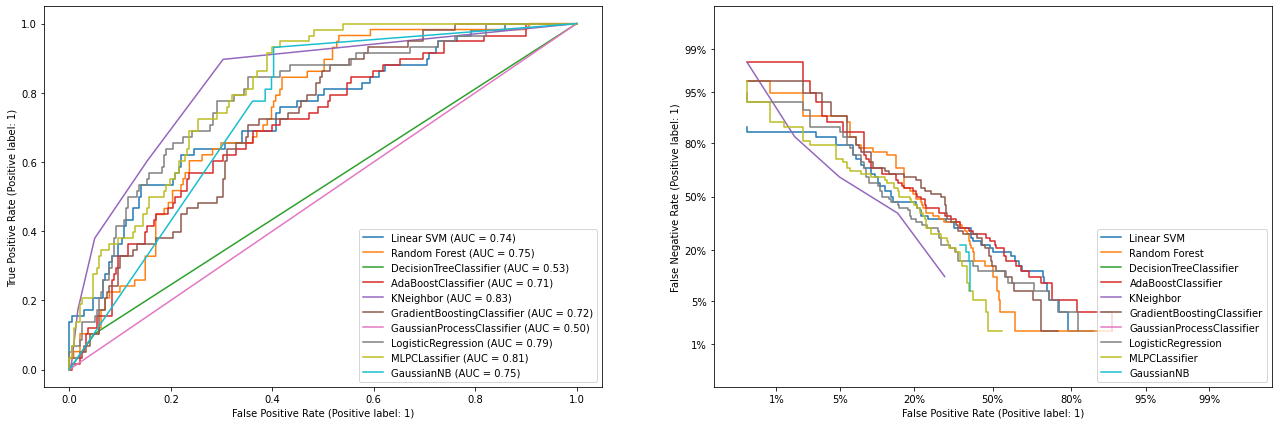

In [97]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_det_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=15, shuffle=True)
X_train, y_train = X_chunks, Y
# X_train, X_test, y_train, y_test = train_test_split(X_fft, Y, test_size=0.33, random_state=15, shuffle=True)
classifiers = {
    "Linear SVM": make_pipeline(StandardScaler(), SVC(gamma='auto', kernel="rbf")),
    "Random Forest": RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, class_weight='balanced'
    ),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(n_estimators=100, random_state=0),
    "KNeighbor": KNeighborsClassifier(n_neighbors=6),
    "GradientBoostingClassifier": GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
    "GaussianProcessClassifier": GaussianProcessClassifier(kernel=1.0 * RBF(1.0),random_state=0),
    "LogisticRegression": LogisticRegression(random_state=0, solver='lbfgs'),
    'MLPCLassifier': MLPClassifier(random_state=1),
    "GaussianNB":GaussianNB()
    
}


fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(22, 7))
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_predict = clf.predict(x_chunks_validation)
    
    print("\n\n" + name + "\n\n")
    print("\n" + "Metrics:" + "\n")
    print(classification_report(y_validation, y_predict))
    print("\n")
    print("\n" + "Confusion Matrix:" + "\n")
    print(confusion_matrix(y_validation, y_predict))
    print("\n____________________________________________\n")

    plot_roc_curve(clf, x_chunks_validation, y_validation, ax=ax_roc, name=name)
    plot_det_curve(clf, x_chunks_validation, y_validation, ax=ax_det, name=name)
plt.show()

In [58]:
unique, counts = np.unique(Y, return_counts=True)
dict(zip(unique, counts))

{0: 1195, 1: 117}

In [ ]:

plot_det_curve(clf, X_test, y_test)
plt.show()

In [ ]:
for i in y_predict:
    print(i, end=" ")

In [ ]:
for i in y_test:
    print(i, end=" ")

# Let's see the spectral characteristics of the signal (doing at the moment)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
id_experiment = 54
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(signals[signals['experiment_id']==id_experiment]['a2_y'], Fs=3000)

plt.xlabel('Time')
plt.title('SpecGram Bearing #2 in experiment {}'.format(id_experiment))
plt.ylabel('Frequency')
plt.show()

In [ ]:
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(raw_signal_a1_y, Fs=3000)

plt.xlabel('Time')
plt.title('SpecGram Bearing #1 in experiment {}'.format(id_experiment))
plt.ylabel('Frequency')
plt.show()

Estimate power spectral density using Welch’s method.

Welch’s method computes an estimate of the power 
spectral density by dividing the data into overlapping segments, 
computing a modified periodogram for each segment and averaging the periodograms.

In [ ]:
import scipy.signal as signal
import plotly.graph_objects as go
id_experiment=92
freqs_first, psd_first = signal.welch(signals[signals['experiment_id']==id_experiment]['a2_y'],fs=3000)
freqs_second, psd_second = signal.welch(signals[signals['experiment_id']==id_experiment]['a1_y'],fs=3000)

fig = go.Figure()
fig.add_trace(go.Scatter(x=freqs_first, y=psd_first,
                    mode='lines',
                    name='First bearing'))
fig.add_trace(go.Scatter(x=freqs_second, y=psd_second,
                    mode='lines',
                    name='second_bearing'))

A vibration FFT (Fast Fourier Transform) spectrum is an incredibly useful tool for machinery vibration analysis. 
FFT spectra allow us to analyze
vibration amplitudes at various component frequencies on the FFT spectrum. 
In this way, we can identify and track vibration occurring at specific frequencies.

In [ ]:
fft_second = get_fft(pd.DataFrame(raw_signal_a2_y), 3000)
fft_first = get_fft(pd.DataFrame(raw_signal_a1_y), 3000)
fig = go.Figure()
fig.add_trace(go.Scatter(x=fft_second.index, y=fft_second.iloc[:,0],
                    mode='lines',
                    name='Second bearing'))
fig.add_trace(go.Scatter(x=fft_first.index, y=fft_first.iloc[:,0],
                    mode='lines',
                    name='First bearing'))

A Power Spectral Density (PSD) is the measure of signal's power content versus frequency. 
A PSD is typically used to characterize broadband random signals. 
The amplitude of the PSD is normalized by the spectral resolution employed to digitize the signal.


In [ ]:
df_psd_first = get_psd(pd.DataFrame(raw_signal_a1_y), 1, 3000)
df_psd_second = get_psd(pd.DataFrame(raw_signal_a2_y), 1, 3000)
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_psd_second.index, y=df_psd_second.iloc[:,0],
                    mode='lines',
                    name='Second bearing'))
fig.add_trace(go.Scatter(x=df_psd_first.index, y=df_psd_first.iloc[:,0],
                    mode='lines',
                    name='First bearing'))

In [ ]:
!pip install tftb

In [ ]:
import tftb

The Wigner distribution (WD) is derived from the relationship between the power spectrum and the autocorrelation function for 
time-variant and non-stationary processes. The WVD has been used for gear fault detection and it is recently used for rolling 
element bearing to represent the time-frequency features of vibration signals.

In [ ]:
sig = raw_signal_a2_y[0:300].to_numpy()
timestamps = experiment_steady_speed['timestamp'][0:300].to_numpy()
wvd = tftb.processing.WignerVilleDistribution(sig, timestamps=timestamps)
tfr_wvd, t_wvd, f_wvd = wvd.run()


dt = 1 /3000
ts = timestamps
f_wvd = np.fft.fftshift(np.fft.fftfreq(tfr_wvd.shape[0], d=2 * dt))
df_wvd = f_wvd[1]-f_wvd[0]  # the frequency step in the WVT
im = plt.imshow(np.fft.fftshift(tfr_wvd, axes=0), aspect='auto', origin='lower',
       extent=(ts[0] - dt/2, ts[-1] + dt/2,
               f_wvd[0]-df_wvd/2, f_wvd[-1]+df_wvd/2))
plt.xlabel('time [s]')
plt.ylabel('frequency [Hz]')
plt.colorbar(im)
plt.title('Wigner-Ville Transform')
plt.show()

#  Get some distribution of signals

In [ ]:
experiment[['a1_y','a2_y']].plot.hist(alpha=0.5, log=True)

In [ ]:
experiment[['a1_y','a2_y']].plot.kde()

In [ ]:
!pip install AntroPy

In [ ]:
import antropy as ent
# ent.spectral_entropy(raw_signal_a2_y, sf=3000, method='fft',normalize=True)
ent.spectral_entropy(raw_signal_a2_y, sf=3000, nperseg=10000)

In [ ]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
rolling_window_a2_y = rolling_window(raw_signal_a2_y.to_numpy(), 10000)
rolling_window_a2_y.shape

In [ ]:
spectral_entropy_list = []
for window in rolling_window_a2_y:
    spectral_entropy_list.append(ent.spectral_entropy(window, sf=3000, method='welch'))

px.line(spectral_entropy_list)

In [ ]:
from scipy import signal
import matplotlib.pyplot as plt
f, t, Sxx = signal.spectrogram(raw_signal_a2_y, 3000)
plt.pcolormesh(t, f[:15], Sxx[:15,:], shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
f, t, Sxx = signal.spectrogram(raw_signal_a1_y, 3000)
plt.pcolormesh(t, f[:15], Sxx[:15,:], shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
import plotly.graph_objects as go
from scipy import signal
analytic_signal = signal.hilbert(raw_signal_a2_y)
amplitude_envelope = np.abs(analytic_signal)
fig = go.Figure()
fig.add_trace(go.Scatter(x=experiment_steady_speed['timestamp'], y=raw_signal_a2_y,
                    mode='lines',
                    name='lines'))
fig.add_trace(go.Scatter(x=experiment_steady_speed['timestamp'], y=amplitude_envelope,
                    mode='lines',
                    name='lines'))
fig.show()

In [ ]:
px.line(get_fft(pd.DataFrame(amplitude_envelope), 3000)[:500])

In [ ]:
px.line(get_psd(pd.DataFrame(amplitude_envelope), 1,3000)[:500])

In [ ]:
experiments = signals['experiment_id'].unique()
data = []
for exp in experiments:
    experiment = signals[(signals['experiment_id']==exp)]
    steady_filter = (experiment['hz'] > 22) & (experiment['hz'] < 27)
    experiment_steady_speed = experiment[steady_filter]
    feature_a1_y = []
    feature_a2_y = []
    for func in list_features_function:
        a1 = func(experiment['a1_y'])
        a2 = func(experiment['a2_y'])
        if type(a1) == list:
            feature_a1_y+=a1
            feature_a2_y+=a2
            
        else:
            feature_a1_y.append(a1)
            feature_a2_y.append(a2)
    data.append((feature_a1_y,feature_a2_y))

    

In [ ]:
!pip install tftb

In [ ]:
!pip install EMD-signal

In [ ]:
from PyEMD import EEMD
import numpy as np
import pylab as plt

# Define signal
t = np.linspace(0, 1, 200)

sin = lambda x,p: np.sin(2*np.pi*x*t+p)
S = 3*sin(18,0.2)*(t-0.2)**2
S += 5*sin(11,2.7)
S += 3*sin(14,1.6)
S += 1*np.sin(4*2*np.pi*(t-0.8)**2)
S += t**2.1 -t

# Assign EEMD to `eemd` variable
eemd = EEMD()

# Say we want detect extrema using parabolic method
emd = eemd.EMD
emd.extrema_detection="parabol"
# Execute EEMD on S
S = experiment_steady_speed['a2_y'].to_numpy()[:3000]
t = experiment_steady_speed['timestamp'].to_numpy()[:3000]
eIMFs = eemd.eemd(S, t)
nIMFs = eIMFs.shape[0]

# Plot results
plt.figure(figsize=(20,15))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(t, S, 'r')

for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    plt.plot(t, eIMFs[n], 'g')
    plt.ylabel("eIMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
plt.savefig('eemd_example', dpi=120)
plt.show()

In [ ]:
px.line(get_fft(pd.DataFrame(eIMFs[2]), 3000))

In [ ]:
corr = signal.correlate(S, np.ones(128), mode='same') / 128
px.line(y=[corr])

In [ ]:
f, Cxy = signal.coherence(t, S, 300, nperseg=1024)
plt.semilogy(f, Cxy)
plt.xlabel('frequency [Hz]')
plt.ylabel('Coherence')
plt.show()

In [ ]:
from scipy import signal
from scipy.fft import fftshift
f, t, Sxx = signal.spectrogram(raw_signal_a2_y, 3000, return_onesided=False)
plt.pcolormesh(t, fftshift(f), fftshift(Sxx, axes=0), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()